## Donchian Breakout with Keltner Exit and Leverage Rotation 


In [33]:
# Imports
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import yfinance as yf
from tqdm.auto import tqdm

# Parameters
USE_SYNTHETIC_LEVERAGE = True

UNDERLYING_TICKER = "^NDX"
SIGNAL_TICKER = UNDERLYING_TICKER

LEV3_TICKER = "TQQQ"
LEV2_TICKER = "QLD"
LEV1_TICKER = "QQQ"

CASH_TICKER = None  # Set to e.g. "BIL" if you want a cash proxy; otherwise cash return is 0.

START = "1985-01-01"
END = None

LAG_DAYS = 1
COMMISSION_RATE = 0.0005
ANNUALIZATION = 252
INIT_CASH = 100_000

DONCHIAN_LEN = 55
KELTNER_EMA_LEN = 20
KELTNER_ATR_LEN = 20
KELTNER_MULT = 2.0
COOLDOWN_DAYS = 10

VOL_LEN = 20
VOL_TH1 = 0.20
VOL_TH2 = 0.30
VOL_TH3 = 0.40

# Optional tuning
RUN_GRID_SEARCH = True
MAX_DD_ALLOWED = 0.45
MIN_RISK_ON_DAYS = 0

print("Active params:", {
    "USE_SYNTHETIC_LEVERAGE": USE_SYNTHETIC_LEVERAGE,
    "UNDERLYING_TICKER": UNDERLYING_TICKER,
    "SIGNAL_TICKER": SIGNAL_TICKER,
    "INSTRUMENTS": (LEV3_TICKER, LEV2_TICKER, LEV1_TICKER, CASH_TICKER),
    "RANGE": (START, END),
    "DONCHIAN_LEN": DONCHIAN_LEN,
    "KELTNER": (KELTNER_EMA_LEN, KELTNER_ATR_LEN, KELTNER_MULT),
    "COOLDOWN_DAYS": COOLDOWN_DAYS,
    "VOL": (VOL_LEN, VOL_TH1, VOL_TH2, VOL_TH3),
    "LAG_DAYS": LAG_DAYS,
    "COMMISSION_RATE": COMMISSION_RATE,
    "MAX_DD_ALLOWED": MAX_DD_ALLOWED,
})


Active params: {'USE_SYNTHETIC_LEVERAGE': True, 'UNDERLYING_TICKER': '^NDX', 'SIGNAL_TICKER': '^NDX', 'INSTRUMENTS': ('TQQQ', 'QLD', 'QQQ', None), 'RANGE': ('1985-01-01', None), 'DONCHIAN_LEN': 55, 'KELTNER': (20, 20, 2.0), 'COOLDOWN_DAYS': 10, 'VOL': (20, 0.2, 0.3, 0.4), 'LAG_DAYS': 1, 'COMMISSION_RATE': 0.0005, 'MAX_DD_ALLOWED': 0.45}


In [34]:
# Data

def _flatten_yf(df: pd.DataFrame, ticker: str | None = None) -> pd.DataFrame:
    if not isinstance(df.columns, pd.MultiIndex):
        return df
    if ticker is not None and ticker in df.columns.get_level_values(1):
        out = df.xs(ticker, level=1, axis=1)
        out.columns = out.columns.astype(str)
        return out
    out = df.copy()
    out.columns = [f"{a}_{b}" for a, b in out.columns.to_list()]
    return out


def build_synthetic_leverage_prices(
    close_under: pd.Series,
    leverage: float,
    start_price: float = 100.0,
) -> pd.Series:
    """Daily-reset constant leverage: price = start_price * cumprod(1 + leverage * r_under). Fees/financing not modeled."""
    r = close_under.pct_change().fillna(0.0).astype(float)
    rL = (leverage * r).clip(lower=-0.99)
    px = start_price * (1.0 + rL).cumprod()
    return px


sig_raw = yf.download(SIGNAL_TICKER, start=START, end=END, auto_adjust=True, progress=False)
sig_raw = _flatten_yf(sig_raw, ticker=SIGNAL_TICKER)

needed = ["Open", "High", "Low", "Close"]
missing = [c for c in needed if c not in sig_raw.columns]
if missing:
    raise ValueError(f"Missing columns {missing} for {SIGNAL_TICKER}. Available: {sig_raw.columns.tolist()}")

sig = sig_raw[needed].rename(columns={
    "Open": "Open_sig",
    "High": "High_sig",
    "Low":  "Low_sig",
    "Close": "Close_sig",
}).dropna()

close_under = sig["Close_sig"].astype(float)

if USE_SYNTHETIC_LEVERAGE:
    close_qqq = build_synthetic_leverage_prices(close_under, leverage=1.0, start_price=100.0).rename(f"Close_{LEV1_TICKER}")
    close_qld = build_synthetic_leverage_prices(close_under, leverage=2.0, start_price=100.0).rename(f"Close_{LEV2_TICKER}")
    close_tqqq = build_synthetic_leverage_prices(close_under, leverage=3.0, start_price=100.0).rename(f"Close_{LEV3_TICKER}")
    trade = pd.concat([close_tqqq, close_qld, close_qqq], axis=1)
else:
    tickers = [LEV3_TICKER, LEV2_TICKER, LEV1_TICKER]
    px_raw = yf.download(tickers, start=START, end=END, auto_adjust=True, progress=False)
    if isinstance(px_raw.columns, pd.MultiIndex):
        close = px_raw["Close"].copy()
    else:
        close = px_raw[["Close"]].copy()
    close.columns = [f"Close_{c}" for c in close.columns]
    trade = close.astype(float)

if CASH_TICKER is not None:
    cash_raw = yf.download(CASH_TICKER, start=START, end=END, auto_adjust=True, progress=False)
    cash_raw = _flatten_yf(cash_raw, ticker=CASH_TICKER)
    if "Close" not in cash_raw.columns:
        raise ValueError(f"{CASH_TICKER} missing Close.")
    trade[f"Close_{CASH_TICKER}"] = cash_raw["Close"].astype(float)

df = sig.join(trade, how="inner").dropna().sort_index()
df = df[~df.index.duplicated(keep="first")]

df["ret_sig"] = df["Close_sig"].pct_change().fillna(0.0).astype(float)
for t in [LEV3_TICKER, LEV2_TICKER, LEV1_TICKER]:
    df[f"ret_{t}"] = df[f"Close_{t}"].pct_change().fillna(0.0).astype(float)

if CASH_TICKER is not None:
    df[f"ret_{CASH_TICKER}"] = df[f"Close_{CASH_TICKER}"].pct_change().fillna(0.0).astype(float)

display(df.head())
display(df.tail())
print("Date range:", df.index.min().date(), "->", df.index.max().date())
print("Columns OK:", [c for c in df.columns if c.startswith("Close_")][:10], "...")


,Open_sig,High_sig,Low_sig,Close_sig,Close_TQQQ,Close_QLD,Close_QQQ,ret_sig,ret_TQQQ,ret_QLD,ret_QQQ
Date,,,,,,,,,,,
1985-10-01,110.620003,112.160004,110.565002,112.139999,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,0.000000
1985-10-02,112.139999,112.540001,110.779999,110.824997,96.482069,97.654713,98.827356,-0.011726,-0.035179,-0.023453,-0.011726
1985-10-03,110.839996,111.184998,110.120003,110.870003,96.599613,97.734028,98.867490,0.000406,0.001218,0.000812,0.000406
1985-10-04,110.870003,110.870003,109.855003,110.074997,94.521578,96.332402,98.158550,-0.007171,-0.021512,-0.014341,-0.007171
1985-10-07,110.074997,110.135002,108.175003,108.199997,89.691381,93.050580,96.486532,-0.017034,-0.051102,-0.034068,-0.017034


,Open_sig,High_sig,Low_sig,Close_sig,Close_TQQQ,Close_QLD,Close_QQQ,ret_sig,ret_TQQQ,ret_QLD,ret_QQQ
Date,,,,,,,,,,,
2025-12-26,25692.679688,25716.710938,25620.320312,25644.390625,325922.623523,345222.394723,22868.192228,-0.000458,-0.001375,-0.000917,-0.000458
2025-12-29,25462.250000,25598.140625,25440.970703,25525.560547,321391.877048,342023.035866,22762.226401,-0.004634,-0.013901,-0.009268,-0.004634
2025-12-30,25509.880859,25577.580078,25456.929688,25462.560547,319012.181422,340334.732001,22706.046625,-0.002468,-0.007404,-0.004936,-0.002468
2025-12-31,25464.710938,25483.769531,25244.859375,25249.849609,311017.221914,334648.507336,22516.363248,-0.008354,-0.025062,-0.016708,-0.008354
2026-01-02,25524.269531,25597.650391,25086.359375,25206.169922,309403.136848,333490.691155,22477.412216,-0.001730,-0.005190,-0.003460,-0.001730


Date range: 1985-10-01 -> 2026-01-02
Columns OK: ['Close_sig', 'Close_TQQQ', 'Close_QLD', 'Close_QQQ'] ...


In [35]:
# Indicators and metrics

def ema(x: pd.Series, length: int) -> pd.Series:
    return x.ewm(span=int(length), adjust=False).mean()


def true_range(high: pd.Series, low: pd.Series, close: pd.Series) -> pd.Series:
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    return pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)


def atr(high: pd.Series, low: pd.Series, close: pd.Series, length: int) -> pd.Series:
    tr = true_range(high, low, close)
    return tr.ewm(span=int(length), adjust=False).mean()


def max_drawdown_from_price(px: pd.Series) -> float:
    px = px.dropna().astype(float)
    if len(px) < 2:
        return np.nan
    dd = px / px.cummax() - 1.0
    return float(dd.min())


def max_drawdown(eq: pd.Series) -> float:
    return max_drawdown_from_price(eq)


def total_return(eq: pd.Series) -> float:
    eq = eq.dropna().astype(float)
    if len(eq) < 1:
        return np.nan
    return float(eq.iloc[-1] - 1.0)


def cagr_from_equity(eq: pd.Series, ann: int = 252) -> float:
    eq = eq.dropna().astype(float)
    if len(eq) < 2:
        return np.nan
    return float(eq.iloc[-1] ** (ann / len(eq)) - 1.0)


def sharpe_from_returns(ret: pd.Series, ann: int = 252) -> float:
    ret = ret.dropna().astype(float)
    if len(ret) < 30:
        return np.nan
    return float(ret.mean() / (ret.std(ddof=0) + 1e-12) * np.sqrt(ann))


def sortino_annualized(ret: pd.Series, mar: float = 0.0, periods: int = 252) -> float:
    ret = ret.dropna().astype(float)
    if len(ret) < 30:
        return np.nan
    excess = ret - mar
    downside = excess[excess < 0]
    dd = downside.std(ddof=0)
    mu = excess.mean()
    if dd == 0:
        return float(np.inf if mu > 0 else (-np.inf if mu < 0 else 0.0))
    return float((mu / dd) * np.sqrt(periods))


def win_rate(ret: pd.Series) -> float:
    ret = ret.dropna().astype(float)
    if len(ret) == 0:
        return np.nan
    return float((ret > 0).mean())


def profit_factor(ret: pd.Series) -> float:
    ret = ret.dropna().astype(float)
    if len(ret) == 0:
        return np.nan
    gains = ret[ret > 0].sum()
    losses = -ret[ret < 0].sum()
    if losses == 0:
        return float(np.inf if gains > 0 else np.nan)
    return float(gains / losses)


In [36]:
def build_regime_donchian_keltner(df: pd.DataFrame) -> pd.Series:
    """Regime: long on Donchian breakout, exit on Keltner lower band, with cooldown."""

    don_len = int(DONCHIAN_LEN)
    ema_len = int(KELTNER_EMA_LEN)
    atr_len = int(KELTNER_ATR_LEN)
    mult = float(KELTNER_MULT)
    cooldown_days = int(COOLDOWN_DAYS)

    close = df["Close_sig"].astype(float)
    high = df["High_sig"].astype(float)
    low = df["Low_sig"].astype(float)

    donchian_high = high.shift(1).rolling(window=don_len, min_periods=don_len).max()
    basis = ema(close, ema_len)
    atr_sig = atr(high, low, close, atr_len)
    keltner_lower = basis - mult * atr_sig

    regime = np.zeros(len(df), dtype=int)
    s = 0
    cooldown = 0

    for i in range(len(df)):
        if cooldown > 0:
            regime[i] = 0
            cooldown -= 1
            continue

        entry_ok = bool(close.iat[i] > donchian_high.iat[i]) if np.isfinite(donchian_high.iat[i]) else False
        exit_ok = bool(close.iat[i] < keltner_lower.iat[i]) if np.isfinite(keltner_lower.iat[i]) else False

        if s == 0:
            if entry_ok:
                s = 1
        else:
            if exit_ok:
                s = 0
                cooldown = cooldown_days

        regime[i] = s

    return pd.Series(regime, index=df.index, name="regime")


In [37]:
def backtest_rotation(df: pd.DataFrame) -> dict:
    lag = int(LAG_DAYS)
    vol_len = int(VOL_LEN)
    vol_th1 = float(VOL_TH1)
    vol_th2 = float(VOL_TH2)
    vol_th3 = float(VOL_TH3)
    ann = int(ANNUALIZATION)
    comm = float(COMMISSION_RATE)

    regime = build_regime_donchian_keltner(df)
    desired = regime.shift(lag).fillna(0).astype(int)

    vol = (
        df["ret_sig"]
        .rolling(window=vol_len, min_periods=vol_len)
        .std(ddof=0)
        * np.sqrt(ann)
    )

    def choose_asset_from_vol(v: float) -> str:
        if not np.isfinite(v):
            return CASH_TICKER if CASH_TICKER is not None else "CASH"
        if v < vol_th1:
            return LEV3_TICKER
        if v < vol_th2:
            return LEV2_TICKER
        if v < vol_th3:
            return LEV1_TICKER
        return CASH_TICKER if CASH_TICKER is not None else "CASH"

    held = []
    for i in range(len(df)):
        if desired.iat[i] == 0:
            held.append(CASH_TICKER if CASH_TICKER is not None else "CASH")
        else:
            held.append(choose_asset_from_vol(float(vol.iat[i])))

    held = pd.Series(held, index=df.index, name="held_asset")

    def asset_ret_for_day(ticker: str, dt) -> float:
        if ticker == "CASH":
            return 0.0
        col = f"ret_{ticker}"
        if col not in df.columns:
            avail = [c for c in df.columns if c.startswith("ret_")]
            suffix = " ..." if len(avail) > 10 else ""
            raise KeyError(f"Missing {col}. Available: {avail[:10]}{suffix}")
        return float(df.loc[dt, col])

    gross = pd.Series(
        [asset_ret_for_day(held.iat[i], df.index[i]) for i in range(len(df))],
        index=df.index,
        name="gross_returns",
    )

    prev = held.shift(1)

    def is_cash(x: str) -> bool:
        return (x == "CASH") or (CASH_TICKER is not None and x == CASH_TICKER)

    def legs(prev_t: str, curr_t: str) -> int:
        if prev_t == curr_t:
            return 0
        prev_cash = is_cash(prev_t)
        curr_cash = is_cash(curr_t)
        if prev_cash and not curr_cash:
            return 1
        if (not prev_cash) and curr_cash:
            return 1
        if (not prev_cash) and (not curr_cash):
            return 2
        return 0

    legs_series = pd.Series(
        [0] + [legs(prev.iat[i], held.iat[i]) for i in range(1, len(df))],
        index=df.index,
        name="legs",
    ).astype(float)

    costs = legs_series * comm
    net = gross - costs

    equity = (1.0 + net).cumprod()
    dd = equity / equity.cummax() - 1.0

    metrics = {
        "TotalReturn": total_return(equity),
        "CAGR": cagr_from_equity(equity, ann=ann),
        "Sharpe": sharpe_from_returns(net, ann=ann),
        "Sortino": sortino_annualized(net, periods=ann),
        "MaxDD": max_drawdown(equity),
        "TurnoverLegs": float(legs_series.sum()),
        "AvgHeld": held.value_counts(normalize=True).to_dict(),
    }

    return {
        "regime": regime,
        "desired": desired,
        "held": held,
        "vol": vol,
        "gross_returns": gross,
        "costs": costs,
        "net_returns": net,
        "equity": equity,
        "drawdown": dd,
        "metrics": metrics,
    }


In [38]:
# Optional grid search (train-only)

if not RUN_GRID_SEARCH:
    print("Grid search disabled (RUN_GRID_SEARCH = False).")
else:
    # --- 80/20 time split (NO leakage) ---
    split_idx = int(len(df) * 0.80)
    df_train = df.iloc[:split_idx].copy()
    df_valid = df.iloc[split_idx:].copy()

    # --- Parameter grid (keep this small) ---
    param_grid = {
    "DONCHIAN_LEN":     [40, 55, 70],
    "KELTNER_EMA_LEN":  [15, 20, 30],
    "KELTNER_ATR_LEN":  [15, 20, 30],
    "KELTNER_MULT":     [1.5, 2.0, 2.5],
    "COOLDOWN_DAYS":    [5, 10, 15],
    "VOL_LEN":          [15, 20, 30],
    "VOL_TH1":          [0.18, 0.22],
    "VOL_TH2":          [0.26, 0.32],
    "VOL_TH3":          [0.38, 0.45],
}
    keys = list(param_grid.keys())
    values = [param_grid[k] for k in keys]
    combos = list(itertools.product(*values))

    results = []
    best = None

    max_dd_allowed = float(globals().get("MAX_DD_ALLOWED", 1.0))
    min_risk_on = int(globals().get("MIN_RISK_ON_DAYS", 0) or 0)

    pbar = tqdm(combos, desc="Grid search", total=len(combos))

    for combo in pbar:
        params = dict(zip(keys, combo))

        if not (params["VOL_TH1"] < params["VOL_TH2"] < params["VOL_TH3"]):
            continue

        DONCHIAN_LEN = int(params["DONCHIAN_LEN"])
        KELTNER_EMA_LEN = int(params["KELTNER_EMA_LEN"])
        KELTNER_ATR_LEN = int(params["KELTNER_ATR_LEN"])
        KELTNER_MULT = float(params["KELTNER_MULT"])
        COOLDOWN_DAYS = int(params["COOLDOWN_DAYS"])

        VOL_LEN = int(params["VOL_LEN"])
        VOL_TH1 = float(params["VOL_TH1"])
        VOL_TH2 = float(params["VOL_TH2"])
        VOL_TH3 = float(params["VOL_TH3"])

        try:
            bt_train = backtest_rotation(df_train)

            if min_risk_on > 0:
                held = bt_train.get("held", None)
                if held is not None:
                    is_cash_mask = (held == "CASH") if (CASH_TICKER is None) else ((held == "CASH") | (held == CASH_TICKER))
                    risk_on_days = int((~is_cash_mask).sum())
                    if risk_on_days < min_risk_on:
                        continue

            sortino = float(bt_train["metrics"]["Sortino"])
            maxdd = float(bt_train["metrics"]["MaxDD"])

            if np.isfinite(maxdd) and (-maxdd > max_dd_allowed):
                continue

            results.append({
                **params,
                "train_sortino": sortino,
                "train_maxdd": maxdd,
            })

            if best is None or sortino > best[0]:
                best = (sortino, params)

            pbar.set_postfix({"best_sortino": (best[0] if best else None), "kept": len(results)})

        except Exception:
            continue

    pbar.close()

    if len(results) == 0:
        raise RuntimeError(
            "No parameter combinations satisfied the MaxDD constraint on TRAIN. "
            "Relax MAX_DD_ALLOWED or shrink window lengths."
        )

    results_df = pd.DataFrame(results).sort_values("train_sortino", ascending=False).reset_index(drop=True)
    display(results_df.head(20))

    BEST_PARAMS = best[1]
    print("Best TRAIN params:", BEST_PARAMS)
    print("Best TRAIN Sortino:", best[0])

    DONCHIAN_LEN = int(BEST_PARAMS["DONCHIAN_LEN"])
    KELTNER_EMA_LEN = int(BEST_PARAMS["KELTNER_EMA_LEN"])
    KELTNER_ATR_LEN = int(BEST_PARAMS["KELTNER_ATR_LEN"])
    KELTNER_MULT = float(BEST_PARAMS["KELTNER_MULT"])
    COOLDOWN_DAYS = int(BEST_PARAMS["COOLDOWN_DAYS"])

    VOL_LEN = int(BEST_PARAMS["VOL_LEN"])
    VOL_TH1 = float(BEST_PARAMS["VOL_TH1"])
    VOL_TH2 = float(BEST_PARAMS["VOL_TH2"])
    VOL_TH3 = float(BEST_PARAMS["VOL_TH3"])

    bt_valid = backtest_rotation(df_valid)
    print("\nVALIDATION metrics (best TRAIN params):")
    for k, v in bt_valid["metrics"].items():
        print(f"{k}: {v}")


Grid search:   0%|          | 0/5832 [00:00<?, ?it/s]

,DONCHIAN_LEN,KELTNER_EMA_LEN,KELTNER_ATR_LEN,KELTNER_MULT,COOLDOWN_DAYS,VOL_LEN,VOL_TH1,VOL_TH2,VOL_TH3,train_sortino,train_maxdd
0,40,30,15,1.5,10,15,0.18,0.26,0.45,1.027914,-0.385018
1,40,30,15,1.5,15,15,0.18,0.26,0.45,1.025488,-0.385018
2,40,30,15,1.5,10,15,0.18,0.26,0.38,1.021127,-0.385018
3,40,30,15,1.5,15,15,0.18,0.26,0.38,1.018682,-0.385018
4,40,30,20,1.5,10,15,0.18,0.26,0.45,1.017496,-0.385018
5,40,30,20,1.5,15,15,0.18,0.26,0.45,1.013638,-0.385018
6,40,30,20,1.5,10,15,0.18,0.26,0.38,1.010768,-0.385018
7,40,30,15,1.5,5,15,0.18,0.26,0.45,1.009209,-0.385018
8,40,30,20,1.5,15,15,0.18,0.26,0.38,1.006892,-0.385018
9,40,30,20,1.5,5,15,0.18,0.26,0.45,1.003534,-0.385018


Best TRAIN params: {'DONCHIAN_LEN': 40, 'KELTNER_EMA_LEN': 30, 'KELTNER_ATR_LEN': 15, 'KELTNER_MULT': 1.5, 'COOLDOWN_DAYS': 10, 'VOL_LEN': 15, 'VOL_TH1': 0.18, 'VOL_TH2': 0.26, 'VOL_TH3': 0.45}
Best TRAIN Sortino: 1.0279135577716025

VALIDATION metrics (best TRAIN params):
TotalReturn: 3.809301656023644
CAGR: 0.21538530643964227
Sharpe: 0.7729806808674301
Sortino: 0.8001612106629886
MaxDD: -0.4810227845333689
TurnoverLegs: 188.0
AvgHeld: {'CASH': 0.42533267619517, 'TQQQ': 0.39674716609167077, 'QLD': 0.13799901429275505, 'QQQ': 0.03992114342040414}


In [39]:
bt = backtest_rotation(df)

print("Metrics:")
for k, v in bt["metrics"].items():
    print(f"{k}: {v}")

display(bt["held"].value_counts(dropna=False))
display(bt["equity"].tail())


Metrics:
TotalReturn: 11425.391077719914
CAGR: 0.2612977383573851
Sharpe: 0.8970034128697916
Sortino: 0.9898135682279856
MaxDD: -0.4810227845333689
TurnoverLegs: 926.0
AvgHeld: {'CASH': 0.424825002464754, 'TQQQ': 0.3852903480232673, 'QLD': 0.12353347135955832, 'QQQ': 0.06635117815242039}


held_asset
CASH    4309
TQQQ    3908
QLD     1253
QQQ      673
Name: count, dtype: int64

Date
2025-12-26    11426.391078
2025-12-29    11426.391078
2025-12-30    11426.391078
2025-12-31    11426.391078
2026-01-02    11426.391078
dtype: float64

/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_13645/2087221396.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = r.resample("M").apply(lambda x: (1.0 + x).prod() - 1.0)


,Train,Validation
Total Return,"206,753.48%",452.39%
CAGR,26.76%,23.65%
Sharpe,0.92,0.82
Sortino,1.03,0.86
Max DD,-38.50%,-48.10%
Win Rate,31.4%,33.4%
Profit Factor,1.22,1.19


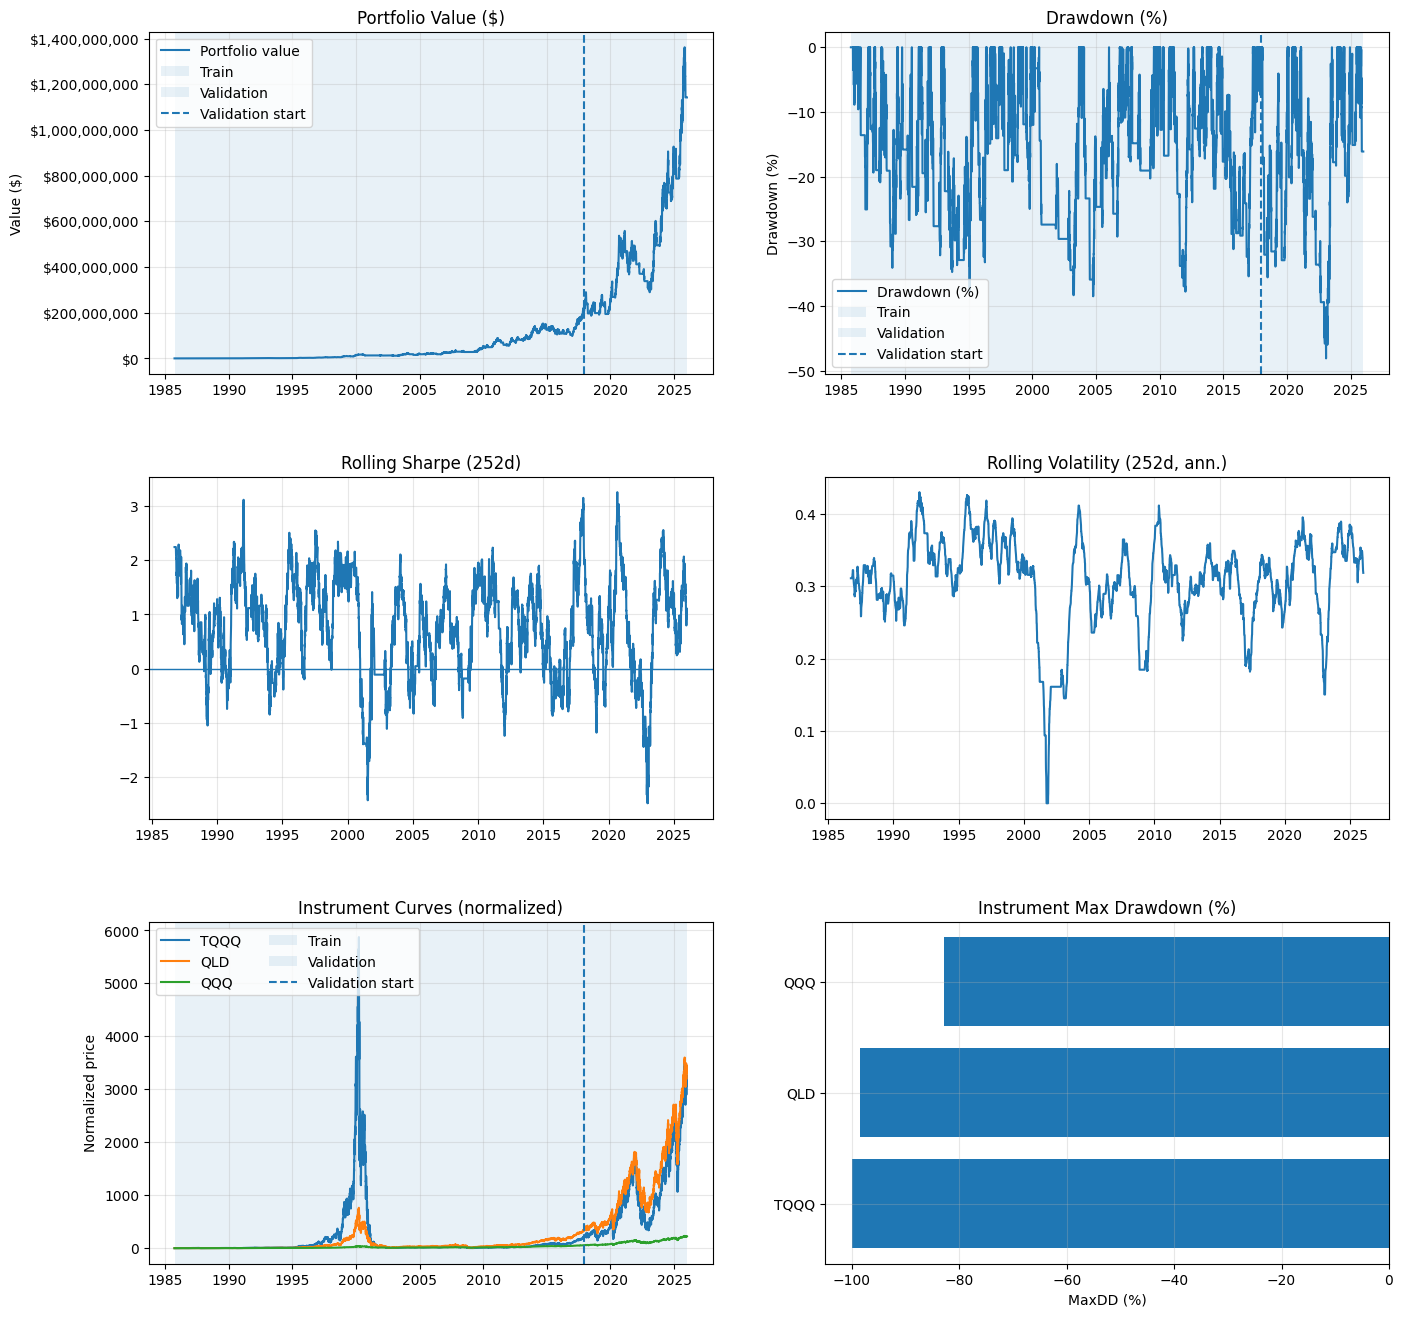

/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_13645/2087221396.py:157: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  year_ret = r.resample("Y").apply(lambda x: (1.0 + x).prod() - 1.0)
/var/folders/qx/88fmh5_123x5dwcpnc3kfz9m0000gn/T/ipykernel_13645/2087221396.py:158: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  year_end_val = portfolio_value.resample("Y").last()


,Year,Year Return (%),"End Value ($) [Start=100,000]"
0,1985,15.80%,"$115,803"
1,1986,43.37%,"$166,025"
2,1987,60.22%,"$266,004"
3,1988,4.43%,"$277,794"
4,1989,35.19%,"$375,554"
5,1990,2.23%,"$383,913"
6,1991,165.19%,"$1,018,107"
7,1992,29.44%,"$1,317,816"
8,1993,-17.14%,"$1,092,007"
9,1994,1.01%,"$1,103,015"


In [40]:
# Performance dashboard

# --- Choose the return series robustly ---
if "net_returns" in bt:
    r = bt["net_returns"].copy()
elif "net" in bt:
    r = bt["net"].copy()
else:
    raise KeyError("Could not find net returns in bt. Expected bt['net_returns'].")

r = pd.Series(r).dropna().astype(float)
r.name = "net_returns"
idx = r.index

# --- 80/20 time split ---
split_idx = int(len(r) * 0.80)
train_idx = idx[:split_idx]
test_idx = idx[split_idx:]
val_start_date = test_idx[0]

# --- Equity / drawdown ---
equity = (1.0 + r).cumprod()
dd = equity / equity.cummax() - 1.0

# --- $ portfolio value ---
start_cash = float(globals().get("INIT_CASH", 100_000.0))
portfolio_value = start_cash * equity

# --- Monthly returns heatmap ---
monthly = r.resample("M").apply(lambda x: (1.0 + x).prod() - 1.0)
monthly_tbl = monthly.to_frame("ret")
monthly_tbl["Year"] = monthly_tbl.index.year
monthly_tbl["Month"] = monthly_tbl.index.month
heat = monthly_tbl.pivot(index="Month", columns="Year", values="ret").sort_index()

# --- Rolling metrics ---
roll_window = 252
roll_sharpe = (r.rolling(roll_window).mean() / (r.rolling(roll_window).std(ddof=0) + 1e-12)) * np.sqrt(252)
roll_vol = r.rolling(roll_window).std(ddof=0) * np.sqrt(252)

# --- Train/validation summary ---
r_train = r.loc[train_idx]
r_test = r.loc[test_idx]

eq_train = (1.0 + r_train).cumprod()
eq_test = (1.0 + r_test).cumprod()

summary_train = {
    "Total Return": f"{total_return(eq_train)*100:,.2f}%",
    "CAGR": f"{cagr_from_equity(eq_train)*100:,.2f}%",
    "Sharpe": f"{sharpe_from_returns(r_train):.2f}",
    "Sortino": f"{sortino_annualized(r_train):.2f}",
    "Max DD": f"{max_drawdown(eq_train)*100:,.2f}%",
    "Win Rate": f"{win_rate(r_train)*100:,.1f}%",
    "Profit Factor": f"{profit_factor(r_train):.2f}",
}

summary_test = {
    "Total Return": f"{total_return(eq_test)*100:,.2f}%",
    "CAGR": f"{cagr_from_equity(eq_test)*100:,.2f}%",
    "Sharpe": f"{sharpe_from_returns(r_test):.2f}",
    "Sortino": f"{sortino_annualized(r_test):.2f}",
    "Max DD": f"{max_drawdown(eq_test)*100:,.2f}%",
    "Win Rate": f"{win_rate(r_test)*100:,.1f}%",
    "Profit Factor": f"{profit_factor(r_test):.2f}",
}

display(pd.DataFrame({"Train": summary_train, "Validation": summary_test}))

def dollars(x, pos):
    return f"${x:,.0f}"

# --- Layout ---
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(3, 2, height_ratios=[1.0, 1.0, 1.0], hspace=0.30, wspace=0.20)

ax_eq = fig.add_subplot(gs[0, 0])
ax_dd = fig.add_subplot(gs[0, 1])
ax_rs = fig.add_subplot(gs[1, 0])
ax_rv = fig.add_subplot(gs[1, 1])
ax_inst = fig.add_subplot(gs[2, 0])
ax_inst_dd = fig.add_subplot(gs[2, 1])

# --- Equity ($) ---
ax_eq.plot(portfolio_value.index, portfolio_value.values, label="Portfolio value")
ax_eq.axvspan(train_idx[0], train_idx[-1], alpha=0.10, label="Train")
ax_eq.axvspan(test_idx[0], test_idx[-1], alpha=0.10, label="Validation")
ax_eq.axvline(val_start_date, linestyle="--", linewidth=1.5, label="Validation start")
ax_eq.set_title("Portfolio Value ($)")
ax_eq.set_ylabel("Value ($)")
ax_eq.yaxis.set_major_formatter(FuncFormatter(dollars))
ax_eq.grid(True, alpha=0.3)
ax_eq.legend(loc="upper left")

# --- Drawdown ---
ax_dd.plot(dd.index, dd.values * 100.0, label="Drawdown (%)")
ax_dd.axvspan(train_idx[0], train_idx[-1], alpha=0.10, label="Train")
ax_dd.axvspan(test_idx[0], test_idx[-1], alpha=0.10, label="Validation")
ax_dd.axvline(val_start_date, linestyle="--", linewidth=1.5, label="Validation start")
ax_dd.set_title("Drawdown (%)")
ax_dd.set_ylabel("Drawdown (%)")
ax_dd.grid(True, alpha=0.3)
ax_dd.legend(loc="lower left")

# --- Rolling Sharpe ---
ax_rs.plot(roll_sharpe.index, roll_sharpe.values)
ax_rs.axhline(0, linewidth=1.0)
ax_rs.set_title(f"Rolling Sharpe ({roll_window}d)")
ax_rs.grid(True, alpha=0.3)

# --- Rolling Vol ---
ax_rv.plot(roll_vol.index, roll_vol.values)
ax_rv.set_title(f"Rolling Volatility ({roll_window}d, ann.)")
ax_rv.grid(True, alpha=0.3)

# --- Instrument curves (normalized) ---
instrument_cols = []
for t in [LEV3_TICKER, LEV2_TICKER, LEV1_TICKER]:
    col = f"Close_{t}"
    if col in df.columns:
        instrument_cols.append((t, col))
if CASH_TICKER is not None and f"Close_{CASH_TICKER}" in df.columns:
    instrument_cols.append((CASH_TICKER, f"Close_{CASH_TICKER}"))

for name, col in instrument_cols:
    px = df.loc[idx, col].dropna()
    if len(px) < 2:
        continue
    px_norm = px / px.iloc[0]
    ax_inst.plot(px_norm.index, px_norm.values, label=name)

ax_inst.axvspan(train_idx[0], train_idx[-1], alpha=0.10, label="Train")
ax_inst.axvspan(test_idx[0], test_idx[-1], alpha=0.10, label="Validation")
ax_inst.axvline(val_start_date, linestyle="--", linewidth=1.5, label="Validation start")
ax_inst.set_title("Instrument Curves (normalized)")
ax_inst.set_ylabel("Normalized price")
ax_inst.grid(True, alpha=0.3)
ax_inst.legend(loc="upper left", ncol=2)

# --- Instrument max drawdowns ---
inst_dd = []
for name, col in instrument_cols:
    px = df.loc[idx, col].dropna()
    if len(px) < 2:
        continue
    inst_dd.append((name, max_drawdown_from_price(px) * 100.0))

inst_dd_df = pd.DataFrame(inst_dd, columns=["Instrument", "MaxDD_%"]).sort_values("MaxDD_%")
ax_inst_dd.barh(inst_dd_df["Instrument"], inst_dd_df["MaxDD_%"].values)
ax_inst_dd.set_title("Instrument Max Drawdown (%)")
ax_inst_dd.set_xlabel("MaxDD (%)")
ax_inst_dd.grid(True, alpha=0.3)

plt.show()

# --- Yearly table (start at INIT_CASH) ---
year_ret = r.resample("Y").apply(lambda x: (1.0 + x).prod() - 1.0)
year_end_val = portfolio_value.resample("Y").last()

yearly_table = pd.DataFrame({
    "Year": year_ret.index.year,
    "Year Return (%)": (year_ret.values * 100.0),
    f"End Value ($) [Start={start_cash:,.0f}]": year_end_val.values,
})

yearly_table["Year Return (%)"] = yearly_table["Year Return (%)"].map(lambda x: f"{x:,.2f}%")
yearly_table[f"End Value ($) [Start={start_cash:,.0f}]"] = yearly_table[f"End Value ($) [Start={start_cash:,.0f}]"].map(lambda x: f"${x:,.0f}")

display(yearly_table)
